Install CRAFT and Vietocr packages

In [ ]:
%%capture

!pip install craft-text-detector
!pip install --quiet vietocr==0.3.2
!mkdir outputs

In [ ]:
import os
import cv2
import sys
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
# Import functions from CRAFT
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)
# Import functions from VietOCR
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [ ]:
def ClearPreOutput():
    # Clear pre-output
    shutil.rmtree('/content/outputs')
    os.remove
    !mkdir outputs

## **CRAFT**

In [ ]:
def TextDetection(ImageName):
    # set image path and export folder directory
    image = ImageName # can be filepath, PIL image or numpy array
    output_dir = 'outputs/'
    image = read_image(image)

    # load models
    refine_net = load_refinenet_model(cuda=False)
    craft_net = load_craftnet_model(cuda=False)

    # perform prediction
    prediction_result = get_prediction(
        image=image,
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.7,
        link_threshold=0.4,
        low_text=0.4,
        cuda=False,
        long_size=1280
    )

    # export detected text regions
    exported_file_paths = export_detected_regions(
        image=image,
        regions=prediction_result["boxes"],
        output_dir=output_dir,
        rectify=True
    )

    # unload models from gpu
    empty_cuda_cache()

## **VietOCR**

In [ ]:
config = Cfg.load_config_from_name('vgg_seq2seq')

In [ ]:
# config['weights'] = './weights/transformerocr.pth'
config['weights'] = 'https://drive.google.com/uc?id=1V8y7MIglONKSdQD04VpBe87Ibvauqirk'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'
config['predictor']['beamsearch']=False

In [ ]:
detector = Predictor(config)

Cached Downloading: /root/.cache/gdown/https-COLON--SLASH--SLASH-drive.google.com-SLASH-uc-QUESTION-id-EQUAL-1V8y7MIglONKSdQD04VpBe87Ibvauqirk
Downloading...
From: https://drive.google.com/uc?id=1V8y7MIglONKSdQD04VpBe87Ibvauqirk
To: /root/.cache/gdown/tmpog4quhd2/dl
100%|██████████| 89.6M/89.6M [00:00<00:00, 172MB/s]


## **Get book info**

In [ ]:
def GetBookInfo1(path):
    # Get all files' name
    files = os.listdir(path)
    files.sort()
    subArr, textArr, length = [], [], files.index(files[-1])+1

    for index in range(files.index(files[-1])+1):
        img = cv2.imread(path + 'crop_' + str(index) + '.png')
        text = detector.predict(Image.open(path + 'crop_' + str(index) + '.png'))
        if (img.shape[0]/img.shape[1]>=3):
            length -= 1
            continue
        # List of height of all images
        subArr.append(img.shape[0])
        # List of label of all images
        textArr.append(text)

    # Each value subArr will be between 0 and 1 (to compare easily)
    Min, Max = np.min(subArr), np.max(subArr)
    for index in range(length):
        subArr[index] = (subArr[index]-Min)/(Max-Min)

    return subArr, textArr, length

**Choose info**

In [ ]:
def GetBookInfo2(subArr, textArr, length):
    TenTG, TenSach, NXB = [], [], []

    # Lay NXB
    index = length-2
    NXB.append(textArr[length-1])
    while (subArr[index]<=0.2 and np.abs(subArr[index+1]-subArr[index])<=0.1):
        NXB.append(textArr[index])
        index -= 1
    NXB.reverse()
    LL, Start = ["nhà", "nha", "nhá", "nhã", "xuất", "xuât", "xuat", "bản", "ban", "bàn", "bán"], 0
    for item in NXB:
        temp = item.lower().split(' ')
        count_exists = 0
        for item_LL in LL:
            if (item_LL in temp):
                count_exists += 1
            if (count_exists==2):
                Start = NXB.index(item)
                break
        if (Start!=0):
            break
    NXB = NXB[Start:]

    # Lay Thong tin sach
    while (subArr[index]<0.24):
        index -= 1
    while (subArr[index]!=1 and index>=0):
        TenSach.append(textArr[index])
        index -= 1
    while (subArr[index]>=0.24 and index>=0):
        TenSach.append(textArr[index])
        index -= 1
    TenSach.reverse()

    # Lay TenTG
    if (index!=-1):
        index = 1
        TenTG.append(textArr[0])
        while (subArr[index]<0.3 and np.abs(subArr[index]-subArr[index-1])<=0.1):
            TenTG.append(textArr[index])
            index += 1
    return TenTG, TenSach, NXB

## **Test**

In [ ]:
! gdown https://drive.google.com/uc?id=1XRzDNP0zEkrzG4PSEizM2RZL0PXbzrwa
! unzip -qq -o ./Test.zip

Downloading...
From: https://drive.google.com/uc?id=1XRzDNP0zEkrzG4PSEizM2RZL0PXbzrwa
To: /content/Test.zip
100% 25.0M/25.0M [00:00<00:00, 200MB/s]


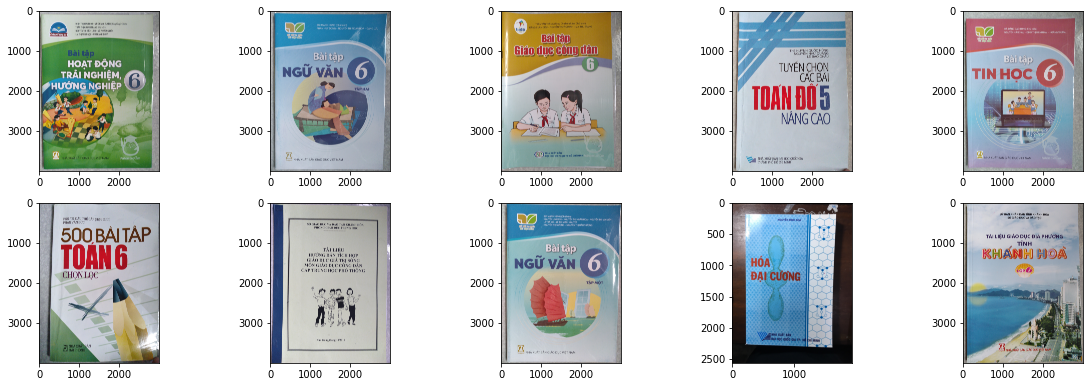

In [ ]:
%matplotlib inline

images = []
for img_path in glob.glob('/content/Test/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [ ]:
path = '/content/outputs/image_crops/'
ls = os.listdir('/content/Test')
ls.sort()
ImgName, TG, TP, NB = [], [], [], []

for filename in ls:
    # Clear pre output
    ClearPreOutput()
    # Detect text in image
    TextDetection('/content/Test/' + filename)
    # List of height, label of each cropped image, length of list
    subArr, textArr, length = GetBookInfo1(path)
    # Get Author's name, Book's title, NXB
    TenTG, TenSach, NXB = GetBookInfo2(subArr, textArr, length)

    ImgName.append(filename)
    TG.append(" ".join(TenTG))
    TP.append(" ".join(TenSach))
    NB.append(" ".join(NXB))

/usr/local/lib/python3.7/dist-packages/craft_text_detector/craft_utils.py:415: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)
/usr/local/lib/python3.7/dist-packages/craft_text_detector/predict.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys_as_ratio = np.array(polys_as_ratio)


In [ ]:
data = {
    'Anh': ImgName,
    'Tac gia': TG,
    'Ten sach': TP,
    'NXB': NB
}
df = pd.DataFrame(data)
df.head(10)

,Anh,Tac gia,Ten sach,NXB
0,1.jpg,THS HUỲNH QUỐC HÙNG NGUYỄN NHƯ QUANG LÊ BẢO CHÂU,TUYEN CHON CÁC BAI TOAN ĐÓ55 NĂNG CAO,NHÀ XUẤT BẢN ĐẠI HỌC QUỐC GIA THÀNH PHỐ HỒ CHÍ...
1,10.jpg,BÙI MẠNH HÙNG (Chủ biên) PHAN HUY DŨNG - NGUYỄ...,Bài tập 6 NGỮ VĂN,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM
2,2.jpg,NGUYỄN ĐÌNH SOA,HÓA ĐẠI CƯƠNG,NHÀ XUẤT BẢN ĐẠI HỌC QUỐC GIA TP HỒ CHÍ MINH
3,3.jpg,SỞ GIÁO DỤC VÀ ĐÀO TẠO KHÁNH HÒA,TÀI LIỆU HƯỚNG DẪN TÍCH HỢP GIÁO DỤC GIÁ TRỊ S...,"Nha trang, tháng 1012010"
4,4.jpg,PGS.TS.ĐẬU THẾ CẤP (Hiệu đính) PHAN VĂN ĐỨC,500 BÀI TẬP TOANG CHỌN LỌC,NHÀ XUẤT BẢN HẢI PHỎNG
5,5.jpg,UỶ BAN NHÂN DÂN TỈNH KHÁNH HOÀ SỞ GIÁO DỤC VÀ ...,TÀI LIỆU GIÁO DỤC ĐỊA PHƯƠNG TỈNH KHANH HOA,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM
6,6.jpg,TRẦN VĂN THẮNG (Tổng Chủ biên kiêm Chủ biên) Đ...,Bài tập Giáo dục công dân 6 NHÀ XUẤT BẢN SP,ĐẠI HỌC SƯ PHẠM TP HỒ CHÍ MINH Fahasa Com
7,7.jpg,ĐINH THỊ KIM THOA - VŨ QUANG TUYÊN (đồng Tồng ...,Bài tập HOẠT ĐỘNG TRẢI NGHIỆM 6 HƯỚNG NGHIỆP,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM Fahasaloom
8,8.jpg,HÀ ĐẶNG CAO TÙNG (Chủ biên) NGUYỄN HẢI CHÂU - ...,Bài tập 6 TIN HỌC,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM Fahasa.clom
9,9.jpg,BÙI MẠNH HÙNG [Chủ biên) NGUYỄN LINH CHI - NGU...,Bài tập 6 NGỮ VĂN,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM


## **Visualize Result**

In [1]:
%%capture

!pip install fuzzywuzzy

In [4]:
from fuzzywuzzy import fuzz
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Upload file xls and csv to Colab
data_xls = pd.read_excel('data_type.xlsx', 'Sheet1', dtype=str, index_col=None)
# Convert xls to csv
data_xls.to_csv('csvfile.csv', encoding='utf-8', index=False)

# data output
data_pre = pd.read_csv('/content/out.csv')
# data type
Actual = pd.read_csv('/content/csvfile.csv')
Actual.head(20)

,Unnamed: 0,Anh,Tac gia,Ten sach,NXB
0,0,1.jpg,THS HUỲNH QUỐC HÙNG NGUYỄN NHƯ QUANG LÊ BẢO CHÂU,TUYỂN CHỌN CÁC BÀI TOÁN ĐỐ 5 NÂNG CAO,NHÀ XUẤT BẢN ĐẠI HỌC QUỐC GIA THÀNH PHỐ HỒ CHÍ...
1,1,2.jpg,BÙI MẠNH HÙNG (Chủ biên) PHAN HUY DŨNG - NGUYỄ...,Bài tập NGỮ VĂN 6,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM
2,2,3.jpg,NGUYỄN TẤT THẮNG (Tổng Chủ biên) - TRẦN THỊ LA...,BÀI TẬP CÔNG NGHỆ 6,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM TP HỒ CHÍ MINH
3,3,4.jpg,NGUYỄN VĂN KHÁNH ĐẶNG THỊ OANH - MAI SỸ TUẤN (...,Bài tập Khoa học tự nhiên 6,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM
4,4,5.jpg,ĐỖ THANH BÌNH - ĐỒ THỊ MINH ĐỨC (đồng Chủ biên...,Bài tập Lịch sử và Đia lí 6,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM
5,5,6.jpg,ĐÔ ĐỨC THÁI,BÀI TẬP Toán TẬP HAI,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM
6,6,7.jpg,NGUYỄN THỊ NHUNG - NGUYỄN XUÂN TIÊN (đồng Tổng...,Bài tập MĨ THUẬT 6,NHÀ XUẤT BẢN GIÁO DỤC VIỆT NAM
7,7,8.jpg,ĐÔ ĐỨC THÁI,BÀI TẬP Toán 6,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM
8,8,9.jpg,TRẦN VĂN THẮNG (Tổng Chủ biên kiêm Chủ biên) N...,Giáo duc công dân 6,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM TP HỒ CHÍ MINH
9,9,10.jpg,LƯU QUANG HIỆP (Tồng Chủ biên) - ĐINH QUANG NG...,GIÁO DỤC THỂ CHẤT 6,NHÀ XUẤT BẢN ĐẠI HỌC SƯ PHẠM


In [6]:
def evaluate_Based_On_Fuzz(str1, str2, Threshold):
  Ratio = fuzz.ratio(str1,str2)
  if Ratio > Threshold:
    return 1
  else:
    return 0

def f1Score(Features, Threshold):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for feature in Features:
      for i in range(len(data_pre)):
        checknull_pre = data_pre[feature].isnull()
        checknull_actual = Actual[feature].isnull()
        if checknull_actual[i]:
          if checknull_pre[i]:
            TN += 1
          else:
            FN += 1
        else:
          if checknull_pre[i]:
            FP += 1
          else:
            if evaluate_Based_On_Fuzz(data_pre[feature][i], Actual[feature][i], Threshold):
              TP += 1
            else:
              FP += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1*100

In [7]:
arr_TenTG, arr_TenSach, arr_NXB, result = [], [], [], []
threshold = [70, 75, 80, 85, 90, 95, 99]

for Threshold in range(70, 100, 5):
    arr_TenTG.append(f1Score(['Tac gia'], Threshold))
    arr_TenSach.append(f1Score(['Ten sach'], Threshold))
    arr_NXB.append(f1Score(['NXB'], Threshold))
    result.append(f1Score(['Tac gia', 'Ten sach', 'NXB'], Threshold))

arr_TenTG.append(f1Score(['Tac gia'], 99))
arr_TenSach.append(f1Score(['Ten sach'], 99))
arr_NXB.append(f1Score(['NXB'], 99))
result.append(f1Score(['Tac gia', 'Ten sach', 'NXB'], 99))

f1-score trên mỗi đặc trưng thông tin

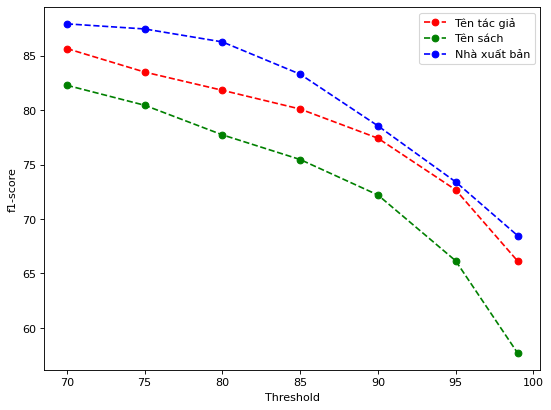

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(threshold, arr_TenTG, linestyle='--', marker='o', color='r', label='Tên tác giả')
plt.plot(threshold, arr_TenSach, linestyle='--', marker='o', color='g', label='Tên sách')
plt.plot(threshold, arr_NXB, linestyle='--', marker='o', color='b', label='Nhà xuất bản')
plt.title("")
plt.xlabel("Threshold")
plt.ylabel("f1-score")
plt.legend()

f1-score trên tất cả đăch trưng của mô hình

No handles with labels found to put in legend.


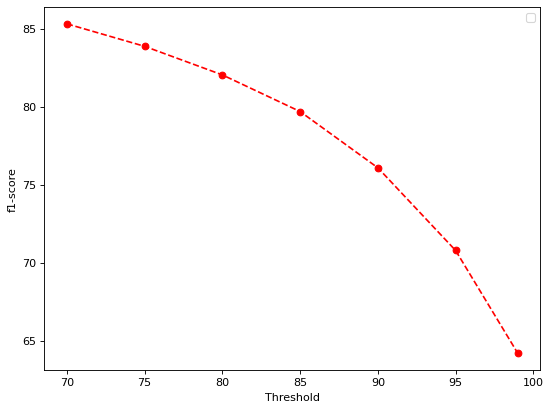

In [9]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(threshold, result, linestyle='--', marker='o', color='r', label='')
plt.xlabel("Threshold")
plt.ylabel("f1-score")
plt.legend()